# Trabalho Final de Álgebra Linear Numérica

Brisa do Nascimento Barbosa

Mateus Krause Eleotério


In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D

# Modelo 2D

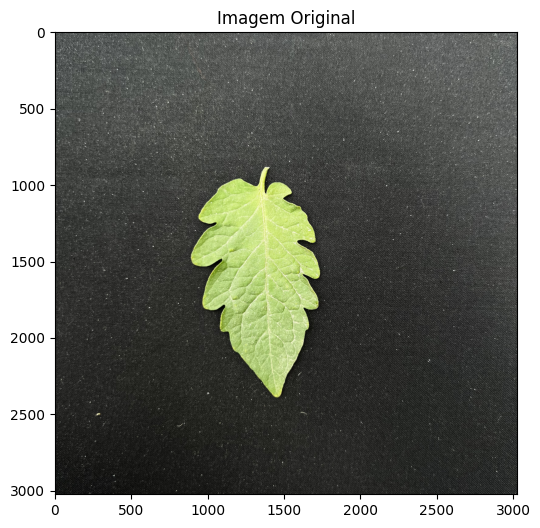

In [51]:
url = "https://raw.githubusercontent.com/mateuskrause/tp-aln/main/DATASET/exemplar_05.JPG"
resp = requests.get(url)
img = np.array(Image.open(BytesIO(resp.content)).convert("RGB"))

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title("Imagem Original")
plt.show()

A imagem original está no formato **RGB** (Red, Green, Blue), que é ótimo para exibição em telas, mas nem sempre é o mais eficiente para segmentação.

Para segmentar **cores específicas** (como o verde da folha), utilizamos o modelo de cores **HSV**:

- **H (Hue / Matiz)**: Representa a **cor** propriamente dita (0 a 180 no OpenCV).
- **S (Saturation / Saturação)**: Representa o quão "viva" é a cor. Cores mais acinzentadas têm saturação baixa.
- **V (Value / Valor)**: Representa o brilho da cor.

O espaço HSV facilita muito a criação de **máscaras baseadas em cor**, pois conseguimos isolar apenas o tom de verde, independentemente da iluminação. Daí, podemos segmentar a cor da folha utilizando intervalos de valores de matiz (Hue), saturação e brilho.

Queremos isolar **tons de verde**, então definimos um intervalo de valores que representam o verde comum:

- Hue: entre 40 e 100 (aproximadamente verde amarelado até verde azulado)
- Saturação e Valor: usamos limites abertos para incluir tons claros e escuros

Usamos `cv2.inRange()` para criar máscara binária (1 onde está verde).  

Depois, aplicamos **operações morfológicas** para limpar ruídos:

- `morphologyEx(..., MORPH_CLOSE)` preenche pequenos buracos na máscara.

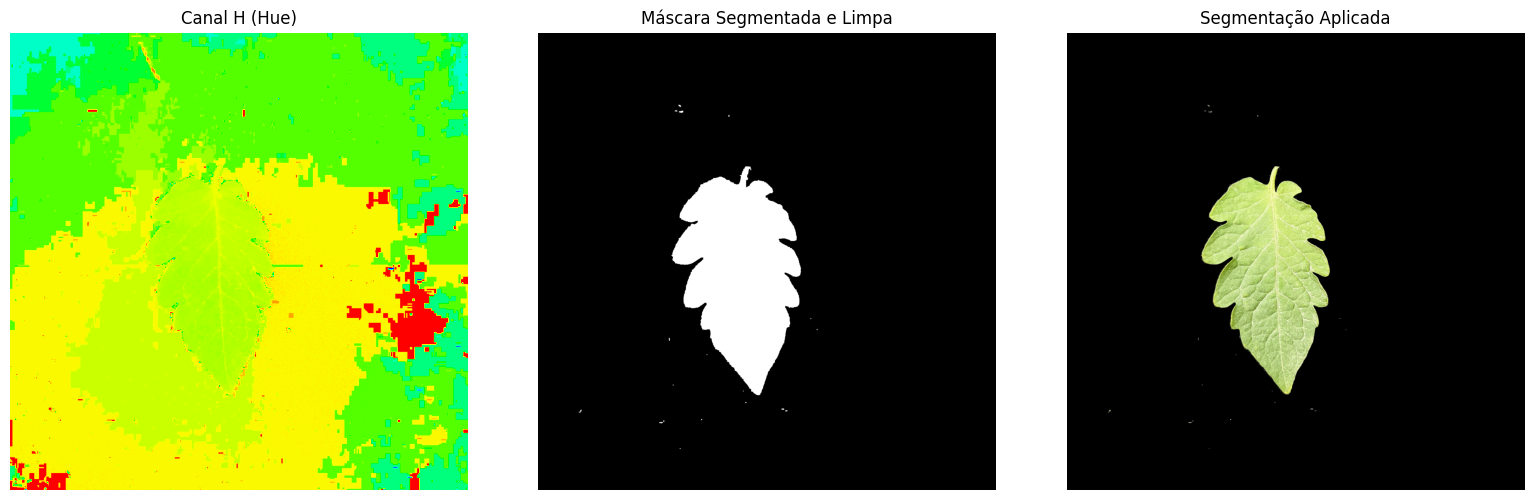

In [52]:
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

lower_green = np.array([30, 40, 40])
upper_green = np.array([90, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)

kernel = np.ones((5, 5), np.uint8)
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel, iterations=1)

# Aplicar máscara na imagem original
masked_img = cv2.bitwise_and(img, img, mask=mask_clean)

fig, axs = plt.subplots(1, 3, figsize=(16, 5))

axs[0].imshow(hsv[:, :, 0], cmap='hsv')
axs[0].set_title("Canal H (Hue)")
axs[1].imshow(mask_clean, cmap='gray')
axs[1].set_title("Máscara Segmentada e Limpa")
axs[2].imshow(masked_img)
axs[2].set_title("Segmentação Aplicada")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

Identificamos o maior contorno da imagem segmentada, que será usado para análise de curvatura. Também garantimos que o contorno seja fechado.

In [53]:
contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contour = max(contours, key=cv2.contourArea).squeeze()
contour_closed = np.vstack([contour, contour[0]])

Usamos derivadas suavizadas com filtro Gaussiano para calcular a curvatura ao longo do contorno. Isso reduz o ruído e facilita a detecção de pontos significativos.

In [55]:
def smooth_derivative(signal, sigma=3.0):
    smoothed = gaussian_filter1d(signal, sigma, axis=0)
    grad = np.gradient(smoothed, axis=0)
    return grad

dx = smooth_derivative(contour_closed[:, 0].astype(float))
dy = smooth_derivative(contour_closed[:, 1].astype(float))
d2x = smooth_derivative(dx)
d2y = smooth_derivative(dy)

curvature = (dx * d2y - dy * d2x) / ((dx**2 + dy**2)**1.5 + 1e-10)
abs_curvature = np.abs(curvature)


Segmentamos o contorno em `num_points` segmentos iguais iguais e, em cada segmento, escolhemos o ponto de maior curvatura local. Isso garante pontos bem distribuídos e relevantes para a forma da borda. Isso garante uma distribuição uniforme e que cada ponto escolhido seja relevante do ponto de vista morfológico.

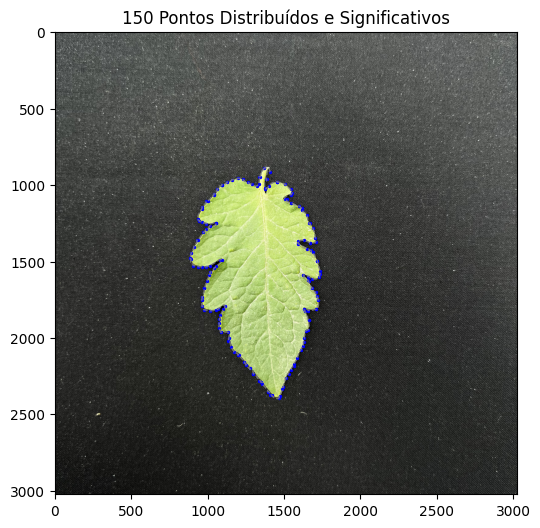

In [ ]:
def significant_points(img, contour_closed, abs_curvature, num_points=100):
    N = len(contour_closed)
    step = N // num_points

    final_indices = []
    for i in range(num_points):
        start = i * step
        end = (i + 1) * step if i < num_points - 1 else N
        region_indices = range(start, end)
        best_idx = max(region_indices, key=lambda idx: abs_curvature[idx])
        final_indices.append(best_idx)

    final_points = contour_closed[final_indices]

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.plot(contour_closed[:, 0], contour_closed[:, 1], '--', color='gray', lw=1, alpha=0.8)
    plt.scatter(final_points[:, 0], final_points[:, 1], c='blue', s=5, marker='o')
    plt.title(f'{num_points} Pontos Distribuídos e Significativos')
    plt.show()

significant_points(img, contour_closed, abs_curvature, num_points=150)

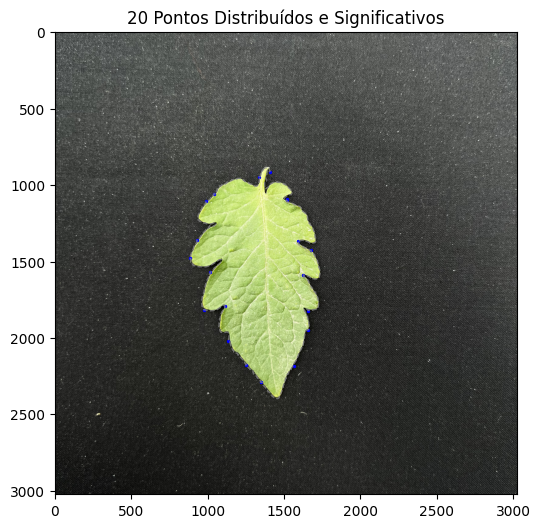

In [59]:
significant_points(img, contour_closed, abs_curvature, num_points=20)

## Interpolação com Splines
Depois de pegar os pontos principais da borda, o próximo passo é reconstruir uma curva suave que passe por eles. Para isso, usamos splines periódicas, que funcionam bem para contornos fechados como o da folha.

**Splines** são funções polinomiais por partes que oferecem várias vantagens para interpolação
- Garantem continuidade até a segunda derivada (C²)
- Adaptam-se a formas complexas sem oscilações indesejadas
-  Mudanças em um ponto afetam apenas regiões próximas

Para contornos **fechados** (como bordas de folhas), splines periódicas são essenciais porque:
- **Continuidade na junção**: Garantem que o início e fim da curva se conectem suavemente
- **Derivadas consistentes**: As derivadas também são contínuas na junção
- **Preservação da forma**: Evitam distorções artificiais próximas ao ponto de fechamento

# Modelo 3D 

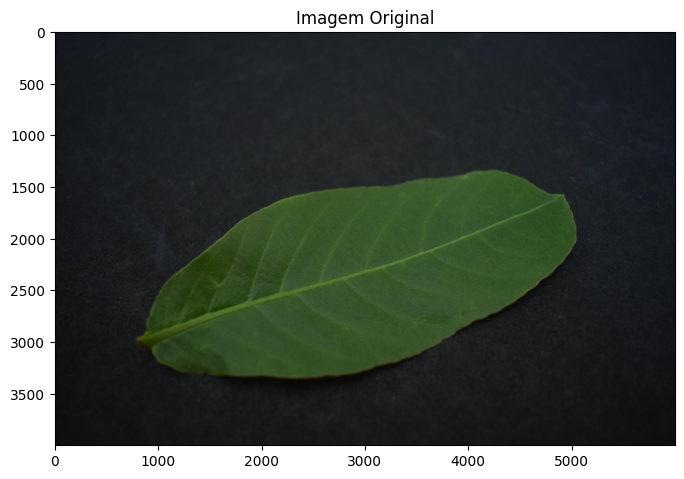

In [42]:
# Download e visualização da imagem
url = "https://raw.githubusercontent.com/mateuskrause/tp-aln/main/DATASET/exemplar_01.JPG"
response = requests.get(url)
img = np.array(Image.open(BytesIO(response.content)))

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title("Imagem Original")
plt.show()

Convertendo a imagem para o espaço de cor HSV e segmentando regiões verdes, como anteriormente.

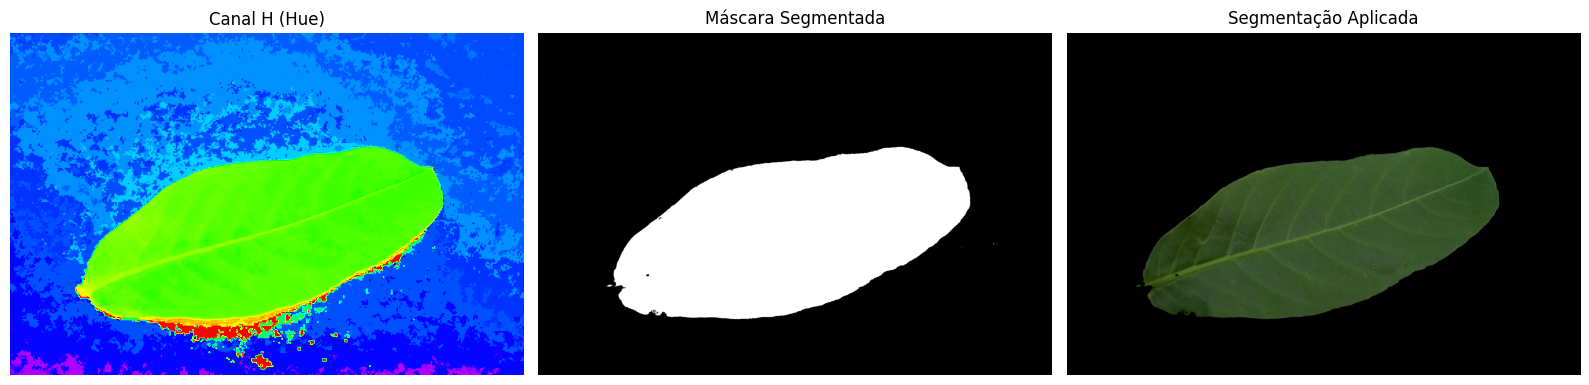

In [32]:
# HSV e máscara
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
lower_green = np.array([40, 50, 50])
upper_green = np.array([100, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)

# Limpeza da máscara
kernel = np.ones((5, 5), np.uint8)
mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Aplicar máscara
masked_img = cv2.bitwise_and(img, img, mask=mask_cleaned)

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(hsv[:, :, 0], cmap='hsv')
axs[0].set_title("Canal H (Hue)")
axs[1].imshow(mask_cleaned, cmap='gray')
axs[1].set_title("Máscara Segmentada")
axs[2].imshow(masked_img)
axs[2].set_title("Segmentação Aplicada")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

Aplicamos o MiDaS (**M**ulti-**D**epth **A**ware **S**ynthesis), que é um modelo de aprendizado profundo desenvolvido para estimar mapas de profundidade monoculares — isto é, profundidade relativa da cena apenas a partir de uma imagem 2D. Ele gera uma imagem em escala de cinza, onde cada pixel indica a profundidade relativa (quanto menor, mais perto).


Using cache found in C:\Users\nbbri/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\nbbri/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\nbbri/.cache\torch\hub\intel-isl_MiDaS_master


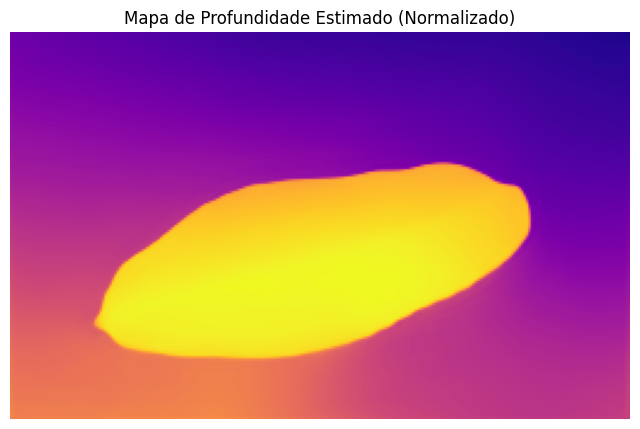

In [43]:
import torch

# Carregar modelo MiDaS e transformações
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
transforms = torch.hub.load("intel-isl/MiDaS", "transforms").small_transform

# Configurar dispositivo (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device).eval()

# Transformar e enviar imagem para dispositivo
inp = transforms(img).to(device)

with torch.no_grad():
    pred = midas(inp)

# Extrair profundidade e normalizar
depth = pred.squeeze().cpu().numpy()
dmin, dmax = depth.min(), depth.max()
depth_n = (depth - dmin) / (dmax - dmin)

# Visualizar mapa de profundidade normalizado
plt.figure(figsize=(8,8))
plt.imshow(depth_n, cmap='plasma')
plt.title("Mapa de Profundidade Estimado (Normalizado)")
plt.axis('off')
plt.show()


O mapa de profundidade gerado por modelos como o MiDaS tem resolução diferente da imagem original, geralmente menor. Para aplicar a segmentação corretamente também na profundidade, precisamos redimensionar a máscara da folha para o mesmo tamanho do mapa de profundidade.

In [44]:
h, w = depth_n.shape
mask_down = cv2.resize(mask_cleaned.astype(np.uint8), (w,h), interpolation=cv2.INTER_NEAREST)

# Normalizar máscara para valores entre 0 e 1
mask_f = mask_down.astype(np.float32) / 255.0
# Aplicar máscara no mapa de profundidade
depth_leaf = depth_n * mask_f

Para identificar bordas precisas da folha na profundidade, extraímos um "anel" na borda da máscara:

- Erode a máscara para reduzir sua área.
- Subtrai a máscara erodida da original para obter um anel nas bordas.

Caso existam vários anéis, mantemos apenas o maior, que corresponde à borda principal da folha.

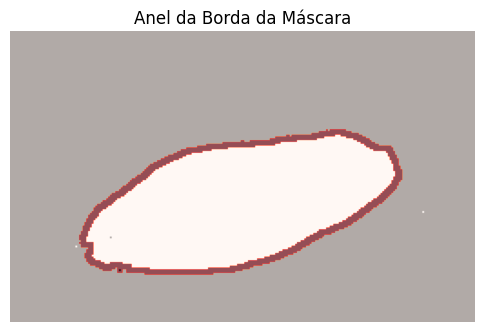

In [47]:
# Erosão para criar anel
eroded = cv2.erode(mask_down, np.ones((7,7), np.uint8))

# Anel = máscara original menos erodida
rim = ((mask_down - eroded) > 0).astype(np.uint8)

# Encontrar contornos do anel
contours, _ = cv2.findContours(rim, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) > 0:
    # Maior contorno
    largest_contour = max(contours, key=cv2.contourArea)
    rim_largest = np.zeros_like(rim)
    cv2.drawContours(rim_largest, [largest_contour], -1, 1, thickness=cv2.FILLED)

    eroded_largest = cv2.erode(rim_largest, np.ones((7,7), np.uint8))
    rim = ((rim_largest - eroded_largest) > 0).astype(np.uint8)

plt.figure(figsize=(6,6))
plt.imshow(mask_down, cmap='gray')
plt.imshow(rim, cmap='Reds', alpha=0.7)
plt.title("Anel da Borda da Máscara")
plt.axis('off')
plt.show()


Para identificar detalhes importantes na forma e na superfície da folha, aplicamos o detector de bordas Canny, tanto na imagem 2D quanto no mapa de profundidade.

No mapa de profundidade, o objetivo é realçar mudanças bruscas de relevo, como nervuras e dobras. Já na máscara da folha, buscamos realçar o contorno geométrico da folha.

Usamos dois pares de limiares diferentes para ajustar a sensibilidade:
- Na máscara 2D: limiares mais altos (100–200), pois a imagem é limpa
- No mapa de profundidade: limiares mais baixos (50–150), para captar variações suaves

Após detectar as bordas, aplicamos a máscara do anel da borda para filtrar apenas as bordas próximas ao contorno da folha. 

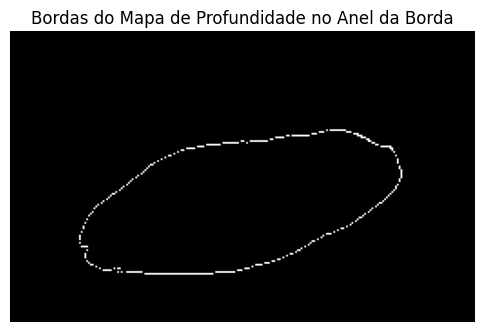

In [48]:
# Detector Canny na máscara downsized para bordas
edges_mask = cv2.Canny(mask_down, 100, 200)

# Detector Canny no mapa de profundidade para bordas
depth_uint8 = np.uint8(depth_leaf * 255)
edges_depth = cv2.Canny(depth_uint8, 50, 150)

# Filtrar bordas para a região do anel
edges_ring = cv2.bitwise_and(edges_depth, edges_depth, mask=rim.astype(np.uint8))

# Plot
plt.figure(figsize=(6,6))
plt.imshow(edges_ring, cmap='gray')
plt.title("Bordas do Mapa de Profundidade no Anel da Borda")
plt.axis('off')
plt.show()


Calculamos o gradiente da profundidade na região do anel para detectar onde há mudanças significativas. Ooperador de Sobel, que estima a variação da profundidade nas direções horizontal (grad_x) e vertical (grad_y). A partir desses dois componentes, obtemos a magnitude do gradiente, que representa a intensidade da mudança de relevo em cada ponto da folha.

Enquanto **Canny** detecta bordas bem definidas, **gradientes** capturam:
- **Mudanças gradativas**: Transições suaves mas significativas
- **Intensidade quantitativa**: Não apenas presença, mas magnitude da mudança
- **Sensibilidade ajustável**: Limiar pode ser otimizado para cada aplicação

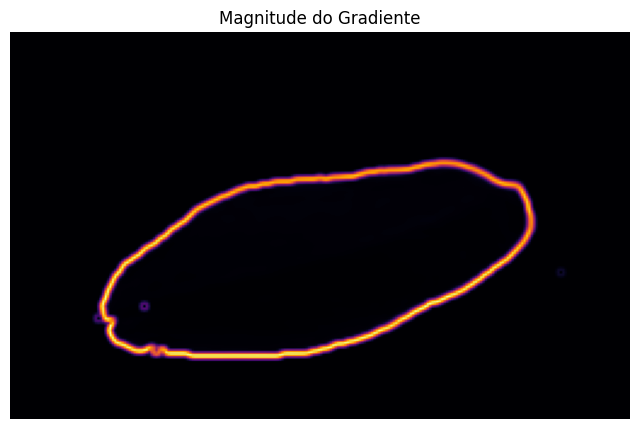

In [50]:
grad_x = cv2.Sobel(depth_leaf, cv2.CV_64F, 1, 0, ksize=5)
grad_y = cv2.Sobel(depth_leaf, cv2.CV_64F, 0, 1, ksize=5)
grad_mag = np.sqrt(grad_x**2 + grad_y**2)

th = 0.04
dges = ((grad_mag > th) & (rim > 0))

# Visualização
plt.figure(figsize=(8, 6))
plt.imshow(grad_mag, cmap='inferno')
plt.title("Magnitude do Gradiente")
plt.axis('off')
plt.show()


Assim, rendedizando a superfície 3D da folha com a borda detectada sobreposta, temos algo impreciso.


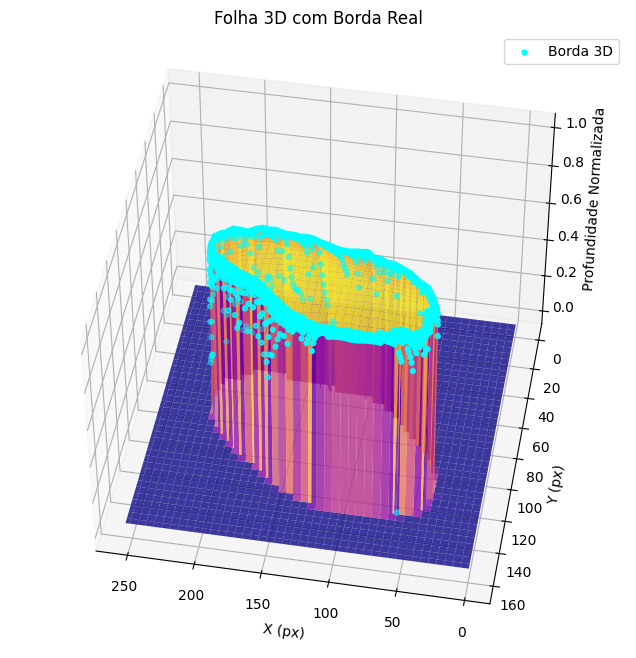

In [38]:
from mpl_toolkits.mplot3d import Axes3D

ys, xs = np.where(dges)
zs = depth_leaf[ys, xs]

h, w = depth_leaf.shape
X, Y = np.meshgrid(np.arange(w), np.arange(h))
Z = depth_leaf

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma', edgecolor='none', alpha=0.8)
ax.scatter(xs, ys, zs, color='cyan', s=12, label='Borda 3D')
ax.set_title('Folha 3D com Borda Real')
ax.set_xlabel('X (px)')
ax.set_ylabel('Y (px)')
ax.set_zlabel('Profundidade Normalizada')
ax.view_init(elev=45, azim=100)
ax.legend()
plt.show()


Calculamos o esqueleto da borda e extraímos os pontos de maior curvatura como candidatos a vértices da folha.

(A **esqueletonização** transforma uma região binária 2D em um conjunto de linhas 1D que mantém a topologia da forma original. Cada ponto do esqueleto é, por definição, aproximadamente equidistante de duas bordas da forma, o que o torna ideal para representar nervuras, lobos e saliências.)

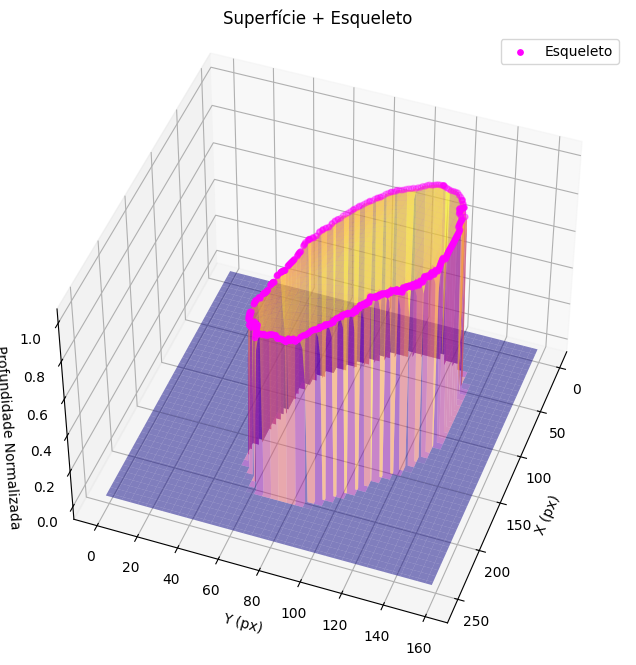

In [39]:
from skimage.morphology import skeletonize

# Geração da máscara binária
binary = ((grad_mag > th) & (rim > 0)).astype(np.uint8)

# Aplicar skeletonize
skeleton = skeletonize(binary)

# Extrair coordenadas do esqueleto
ys_sk, xs_sk = np.where(skeleton)
zs_sk = depth_leaf[ys_sk, xs_sk]

# Plot 3D do esqueleto
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma', edgecolor='none', alpha=0.5)
ax.scatter(xs_sk, ys_sk, zs_sk, color='magenta', s=15, label='Esqueleto')
ax.set_title('Superfície + Esqueleto')
ax.set_xlabel('X (px)')
ax.set_ylabel('Y (px)')
ax.set_zlabel('Profundidade Normalizada')
ax.view_init(elev=45, azim=20)
ax.legend()
plt.show()

Utilizamos **KMeans** para agrupar os pontos do esqueleto e selecionamos os pontos com maior curvatura em cada cluster.

c:\Users\nbbri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


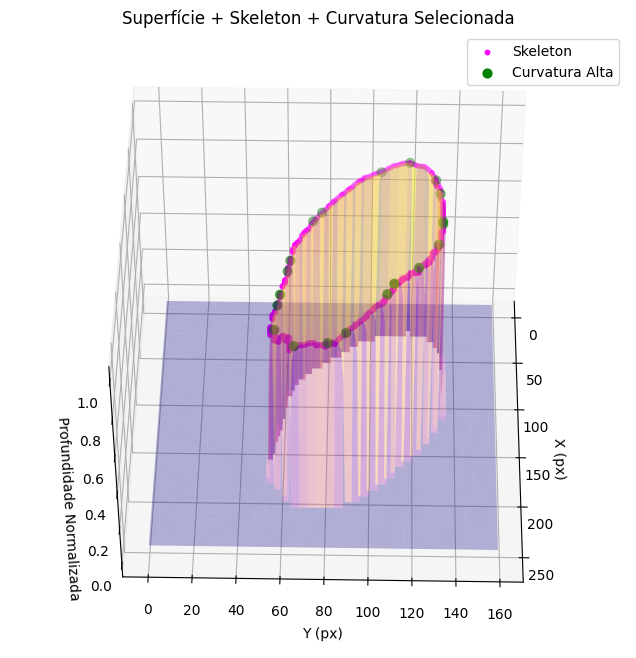

In [40]:
from scipy.ndimage import gaussian_filter1d

# Formar contorno do esqueleto
contour_sk = np.vstack([xs_sk, ys_sk]).T
contour_closed = np.vstack([contour_sk, contour_sk[0]])  # fechar para suavidade

# Função de derivadas suavizadas
def smooth_derivative(signal, sigma=3.0):
    smoothed = gaussian_filter1d(signal, sigma, axis=0)
    grad = np.gradient(smoothed, axis=0)
    return grad

# Derivadas
dx = smooth_derivative(contour_closed[:, 0])
dy = smooth_derivative(contour_closed[:, 1])
d2x = smooth_derivative(dx)
d2y = smooth_derivative(dy)

# Curvatura (absoluta)
curvature = (dx * d2y - dy * d2x) / ((dx**2 + dy**2)**1.5 + 1e-10)
abs_curvature = np.abs(curvature[:-1])  # corresponde à forma de contour_sk

from sklearn.cluster import KMeans

# Número de pontos desejados
num_points = min(20, len(xs_sk))

# KMeans nos pontos XY do esqueleto
kmeans = KMeans(n_clusters=num_points, random_state=42).fit(contour_sk)
labels = kmeans.labels_

# Seleciona o ponto com maior curvatura de cada cluster
final_indices = []
for i in range(num_points):
    cluster_idxs = np.where(labels == i)[0]
    if len(cluster_idxs) == 0:
        continue
    best_idx = cluster_idxs[np.argmax(abs_curvature[cluster_idxs])]
    final_indices.append(best_idx)

# Coordenadas finais
curv_points = contour_sk[final_indices]
z_curv = zs_sk[final_indices]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Superfície
ax.plot_surface(X, Y, Z, cmap='plasma', edgecolor='none', alpha=0.3)

# Esqueleto
ax.scatter(xs_sk, ys_sk, zs_sk, color='magenta', s=10, label='Skeleton')

# Pontos de curvatura
ax.scatter(curv_points[:, 0], curv_points[:, 1], z_curv,
           color='green', s=40, label='Curvatura Alta')

ax.set_xlabel('X (px)')
ax.set_ylabel('Y (px)')
ax.set_zlabel('Profundidade Normalizada')
ax.set_title('Superfície + Skeleton + Curvatura Selecionada')
ax.view_init(elev=45, azim=1)
ax.legend()
plt.show()



Para conferir se está ok, projetamos os pontos de curvatura extraídos no plano da imagem original.


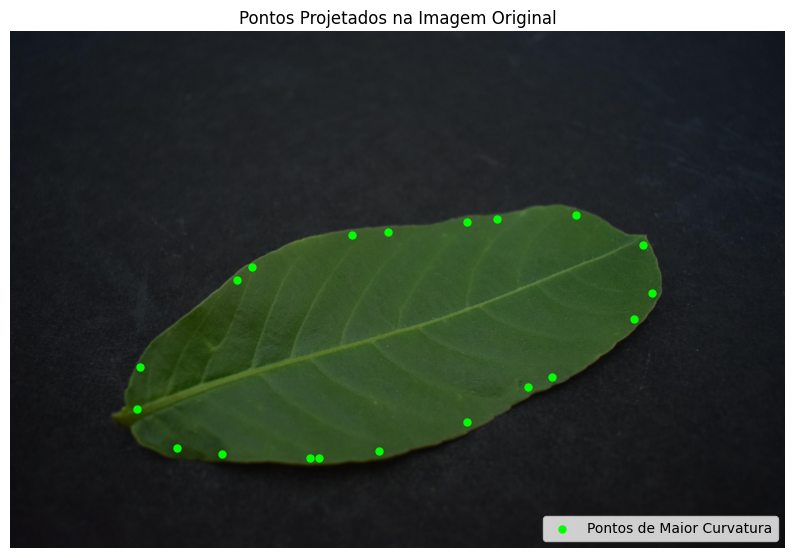

In [41]:
h_orig, w_orig = img.shape[:2]
scale_x = w_orig / w
scale_y = h_orig / h

x_img = curv_points[:, 0] * scale_x
y_img = curv_points[:, 1] * scale_y

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.scatter(x_img, y_img, c='lime', s=25, marker='o', label='Pontos de Maior Curvatura')
plt.axis('off')
plt.title("Pontos Projetados na Imagem Original")
plt.legend(loc='lower right')
plt.show()


## Interpolação com Splines